# MNIST Handwritten Digits and a Modern LeNet-5

In [1]:
%matplotlib notebook

import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from mnist import mnist_data
from mnist import mnist_visuals
from deep_learning import nn_layers
from deep_learning import nn_optimizers
from deep_learning.nn import NeuralNetwork
import models

## 1. Task: Image Recognition for Handwrittten Digits

### MNIST Dataset

The [MNIST database of handwritten digits](http://yann.lecun.com/exdb/mnist/) is one of the canonical datasets for machine learning. Each sample is a 28x28 pixel grayscale image of a handwritten digit. This dataset consists of 60,000 training images and 10,000 test images.

In [2]:
X_train, X_test, y_train, y_test = mnist_data.load_mnist()

Here are some sample images from the training data:

<IPython.core.display.Javascript object>


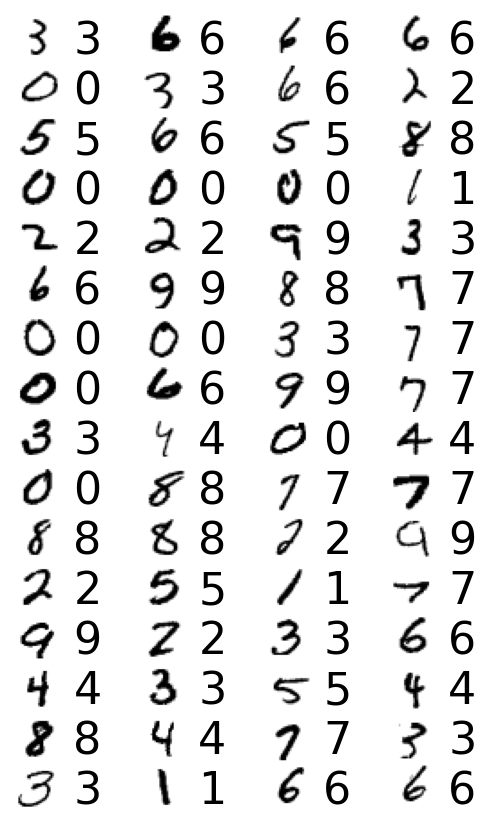

In [3]:
np.random.seed(0)
mnist_visuals.show_images(X_train, y_train)

### Evaluation Criteria

We will use a simple evaluation metric: accuracy against the 10,000 test images.

Some improvements to the metric could be considered:

*   using a macro-average of the accuracy(/recall) for each digit
*   adding a penalty for imbalanced performance (e.g., predictions are much better for 9 than 5)

However, when most people report the results of their ML model against the MNIST database, accuracy is used as the standard metric.

We will also look at the time for both training and predictions. Here, we will have the following two scenarios in mind:

1.  **Developing a ML model**: During development, we will often iterate throuh many models. In practice, the training time is the primary driver for the speed of a single iteration. The faster a single iteration is, the more quickly we can iterate through different models.
1.  **Deploying a ML model**: Once the model has already been trained and is deployed in production, only the prediction time matters.

For reference, these models were trained on a laptop with an [Intel i7-8565U CPU](https://ark.intel.com/content/www/us/en/ark/products/149091/intel-core-i7-8565u-processor-8m-cache-up-to-4-60-ghz.html).

## 2. Classical Machine Learning

Before we use deep learning, let's first try some classical machine learning models as a baseline:

*   Naive Bayes
*   Logistic Regression
*   K Nearest Neighbors

For these models, we will use the default settings from `sklearn`, though we will set `njobs=-1` to parallelize and speed up the training if possible.

Some basic preprocessing will be used: the 28x28 pixels were flattened into 784 features, and each pixel was rescaled from 0-255 to 0.0-1.0.

In [4]:
X_train_flat = mnist_data.preprocess_flat(X_train)
X_test_flat = mnist_data.preprocess_flat(X_test)

### Naive Bayes

In [5]:
gnb = GaussianNB()
models.train_sklearn(gnb, X_train_flat, y_train)

Train: 0:00:00.488


The training time is negligible.

Predict: 0:00:00.320
  Score: 55.58%


<IPython.core.display.Javascript object>


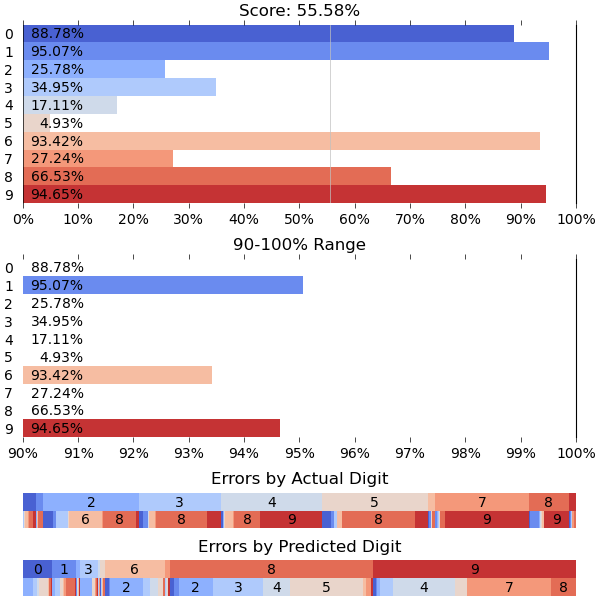

In [6]:
y_pred_gnb, Y_prob_gnb = models.evaluate_sklearn(gnb, X_test_flat, y_test)
mnist_visuals.show_performance(y_test, y_pred_gnb)

The performance, while significanty better than random guessing (10%), is abysmal. Furthermore, the performance is also extremely imbalanced. E.g., this model is very accurate at identifying 1's, but it almost never identifies 5's. On the bright side, predictions are lightning-fast.

When it makes an error, most of the time it incorrectly predicts an 8 or a 9. Let's dive into some samples where either of these digits were predicted:

<IPython.core.display.Javascript object>


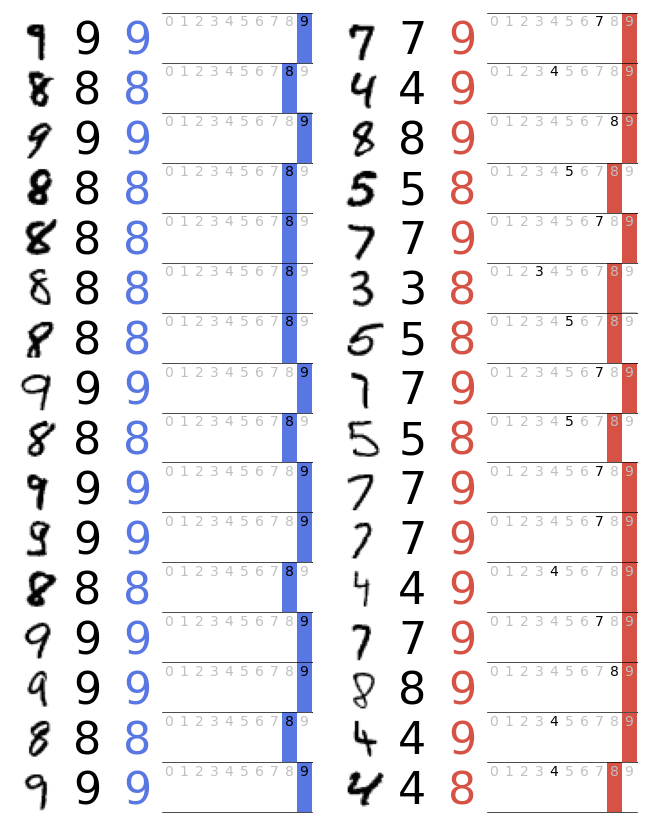

In [7]:
np.random.seed(0)
mnist_visuals.show_predictions(X_test, y_test, y_pred_gnb, Y_prob_gnb, pred_digits=[8, 9])

All of these incorrect predictions are for digits that a human could very easily recognize. Furthermore, the model is very over-confident with its predictions, consistently assigning a probabilty of almost 100% to the predicted digit.

Finally, we can use the parameters learned by naive Bayes to construct an "average" image for each digit:

<IPython.core.display.Javascript object>


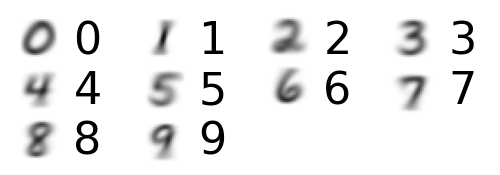

In [8]:
X_nb = gnb.theta_.reshape((10, 28, 28)) * 255
y_nb = np.arange(10)
mnist_visuals.show_images(X_nb, y_nb)

### Logistic Regression

In [9]:
lr = LogisticRegression(n_jobs=-1)
models.train_sklearn(lr, X_train_flat, y_train)

Train: 0:00:33.504


The training time is reasonably fast for the purposes of model development.

Predict: 0:00:00.013
  Score: 92.58%


<IPython.core.display.Javascript object>


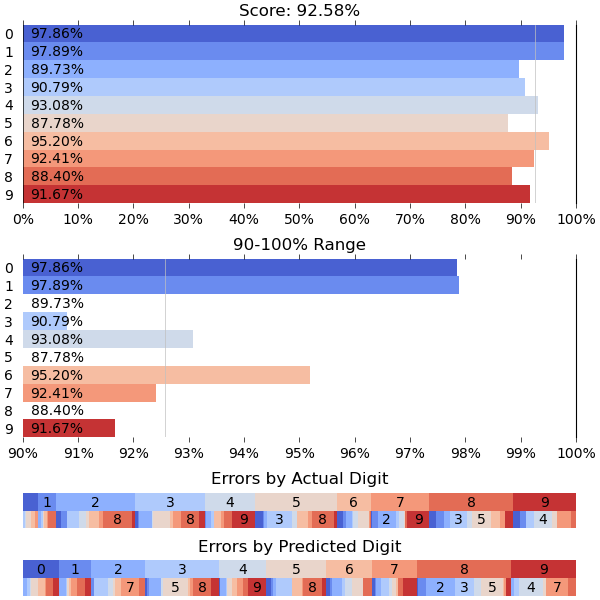

In [10]:
y_pred_lr, Y_prob_lr = models.evaluate_sklearn(lr, X_test_flat, y_test)
mnist_visuals.show_performance(y_test, y_pred_lr)

A performance over 90% is pretty good, though there is room for improvement, and there are no major imbalances. Predictions are still lightning-fast.

Let's take a look at some of the incorrect predictions:

<IPython.core.display.Javascript object>


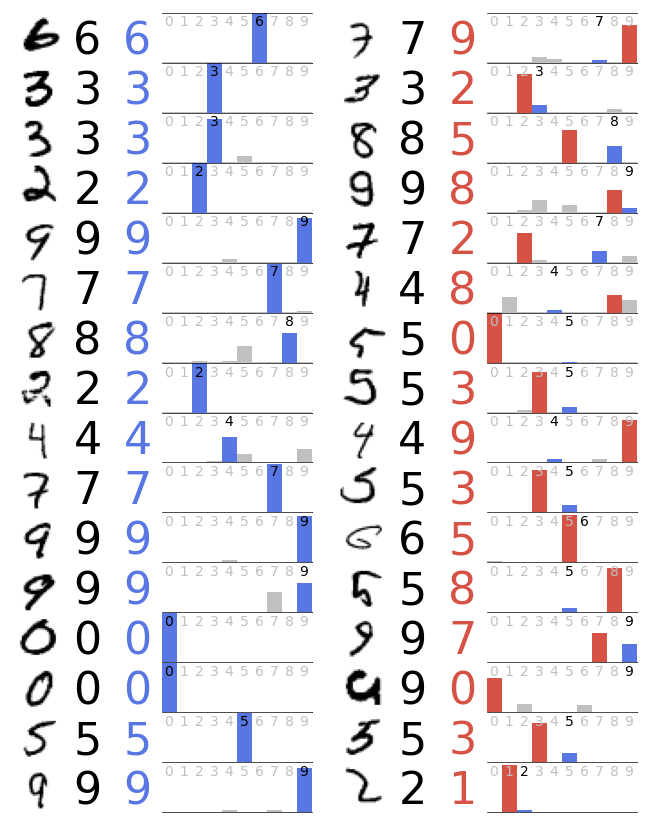

In [11]:
np.random.seed(0)
mnist_visuals.show_predictions(X_test, y_test, y_pred_lr, Y_prob_lr)

Most of these samples could easily be recognized by a human, but there are a few difficult samples here. Furthermore, on many of these predictions, the model does register some uncertainty; the digit with the highest probability is the incorrect digit, but it does assign some probability to the correct digit.

### K Nearest Neighbors

In [12]:
knn = KNeighborsClassifier(n_jobs=-1)
models.train_sklearn(knn, X_train_flat, y_train)

Train: 0:00:13.596


The training time is reasonably fast.

Predict: 0:03:40.812
  Score: 96.88%


<IPython.core.display.Javascript object>


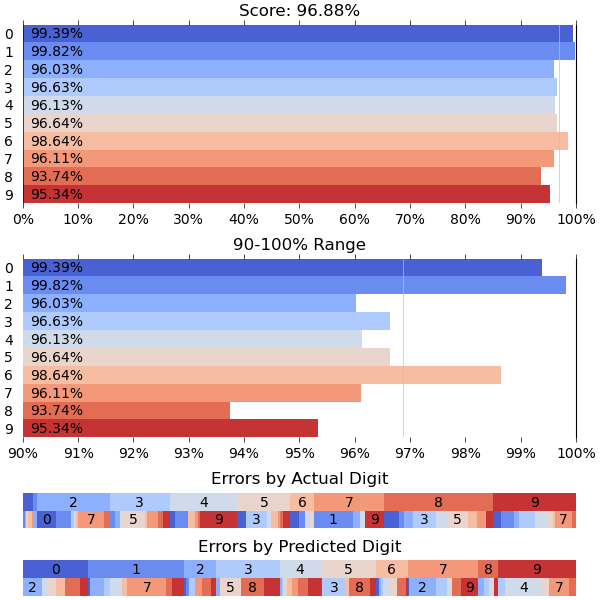

In [13]:
y_pred_knn, Y_prob_knn = models.evaluate_sklearn(knn, X_test_flat, y_test, prob=False)
mnist_visuals.show_performance(y_test, y_pred_knn)

Despite a significant jump in peformance, KNN has a fatal flaw: its predictions are too slow. For 60,000 training images with 784 pixels per image, KNN has to process ~47,000,000 pixels just to make a single prediction.

On top of that, the datasets for modern image recognition tasks tend to have many more images, and each image has both many more pixels and 3 channels (RGB) per pixel. KNN's already slow performance will grind to a halt as the number of images and the number of features per image increases.

## 3. Deep Learning

Next, let's try deep learning and some neural networks. As before, the pixels will be rescaled from 0-255 to 0.0-1.0.

### Learning Strategy

Each network will be trained for 20 epochs using the following learning strategy:

*   Adam optimizer ($\beta_1 = 0.9, \beta_2 = 0.999, \varepsilon = 10^{-8}$)
*   Learning rate: 0.001
*   Mini-batch size: initially 32, doubles every 4 epochs
*   Weight decay: 0.01

For the last 4 epochs (mini-batch size = 512), the epoch with best score will be taken, with ties being broken in favor of later epochs.

**Note:** In this implementation, weight decay is decoupled from the Adam optimizer, and the weight decay term is not included in the moving averages calculated by Adam. For more information on why this matters for performance, see [this paper](https://arxiv.org/pdf/1711.05101.pdf).

In [14]:
seed=501968

### 1-Layer Neural Network

First, let's try the simplest neural network: a network where the inputs are fed directly into the output layer.

In [15]:
def init_nn1l():
    return NeuralNetwork(
        "nn1l",
        preprocess_fn=mnist_data.preprocess_flat,
        hidden_layers=[],
        output_layer=nn_layers.multiclass_output(784, 10),
        optimizer=nn_optimizers.adam())

....................
Train: 0:00:10.304


<IPython.core.display.Javascript object>


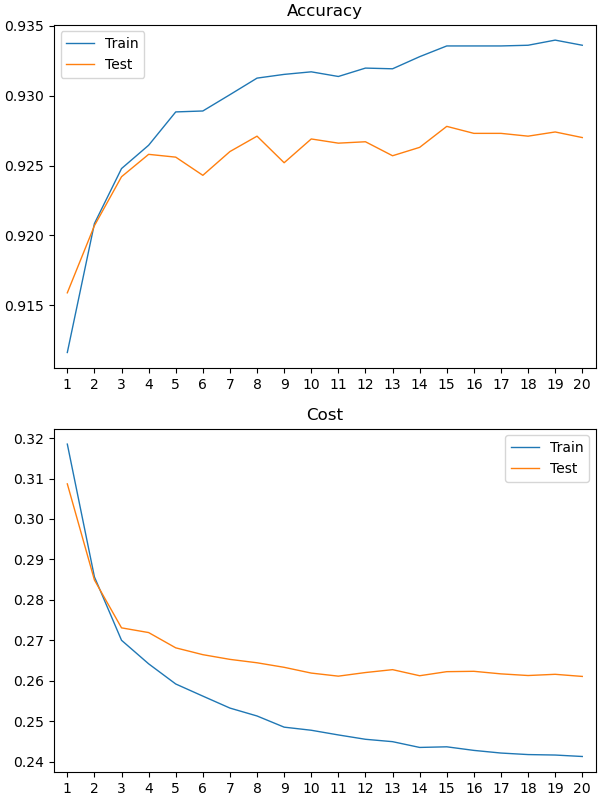

In [16]:
tracker = models.EpochTracker(X_train, X_test, y_train, y_test)
nn1l = models.train_nn(init_nn1l, X_train, X_test, y_train, y_test, seed=seed, epoch_fn=tracker.evaluate_epoch)
tracker.show_training()

This network can be trained in a matter of seconds, which is more than fast enough.

 Params: 7850
Predict: 0:00:00.030
  Score: 92.74%
   Cost: 0.26157103


<IPython.core.display.Javascript object>


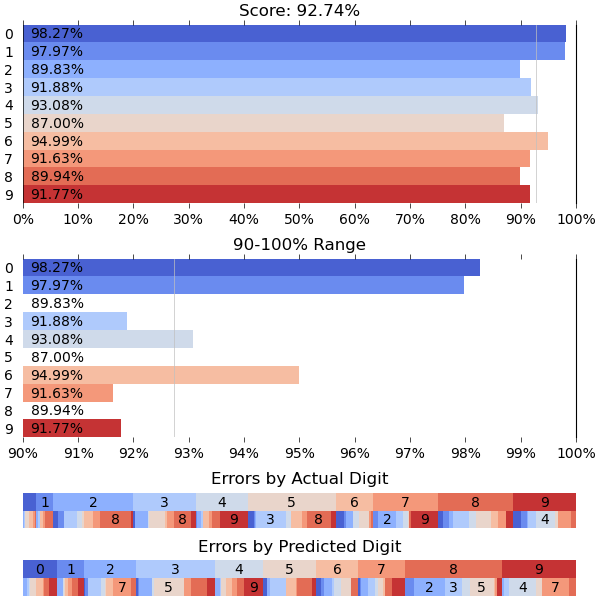

In [17]:
y_pred_nn1l, Y_prob_nn1l = models.evaluate_nn(nn1l, X_test, y_test)
mnist_visuals.show_performance(y_test, y_pred_nn1l)

This neural network is extremely similar to logistic regression. Thus, it should not be surprising the its performance is extremely similar to (in this case, a little better than) logistic regression, and that its predictions are lightning-fast.

### 2-Layer Neural Network

The next network will add a single hidden layer with 300 nodes, using ReLU activation.

In [18]:
def init_nn2l():
    return NeuralNetwork(
        "nn2l",
        preprocess_fn=mnist_data.preprocess_flat,
        hidden_layers=[
            nn_layers.dense(784, 300),
        ],
        output_layer=nn_layers.multiclass_output(300, 10),
        optimizer=nn_optimizers.adam())

....................
Train: 0:01:29.905


<IPython.core.display.Javascript object>


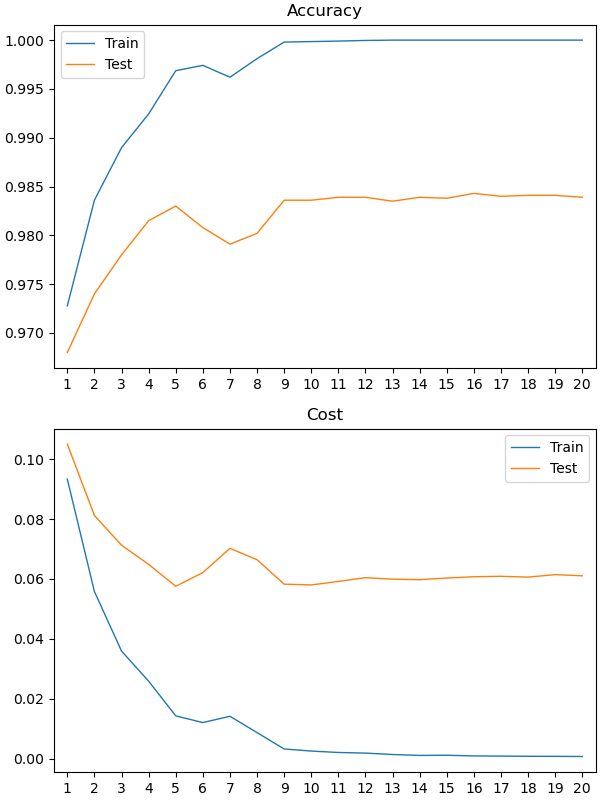

In [19]:
tracker = models.EpochTracker(X_train, X_test, y_train, y_test)
nn2l = models.train_nn(init_nn2l, X_train, X_test, y_train, y_test, seed=seed, epoch_fn=tracker.evaluate_epoch)
tracker.show_training()

This network can be trained in a couple of minutes, which is reasonably fast for the purposes of model development.

 Params: 238510
Predict: 0:00:00.100
  Score: 98.41%
   Cost: 0.06146228


<IPython.core.display.Javascript object>


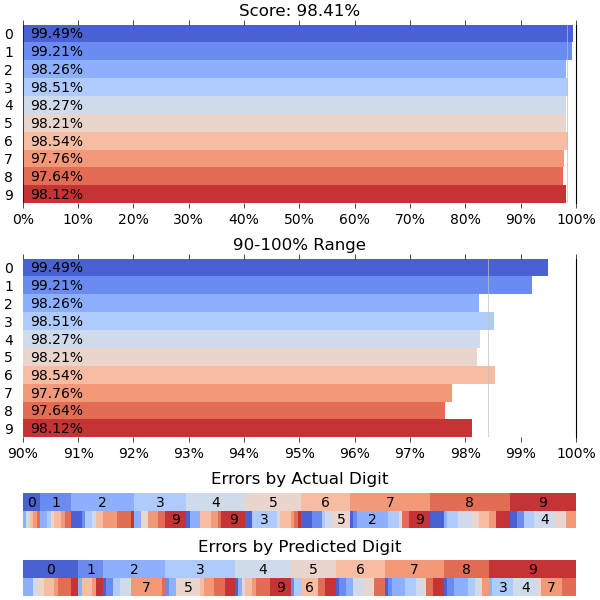

In [20]:
y_pred_nn2l, Y_prob_nn2l = models.evaluate_nn(nn2l, X_test, y_test)
mnist_visuals.show_performance(y_test, y_pred_nn2l)

This network makes a huge jump in accuracy, with an accuracy well over 98%. Furthermore, its predictions are still lightning-fast. However, this network has nearly 240,000 parametes to train.

### 3-Layer Neural Network

The next network will add a second hidden layer with 100 nodes.

In [21]:
def init_nn3l():
    return NeuralNetwork(
        "nn3l",
        preprocess_fn=mnist_data.preprocess_flat,
        hidden_layers=[
            nn_layers.dense(784, 300),
            nn_layers.dense(300, 100),
        ],
        output_layer=nn_layers.multiclass_output(100, 10),
        optimizer=nn_optimizers.adam())

....................
Train: 0:01:45.813


<IPython.core.display.Javascript object>


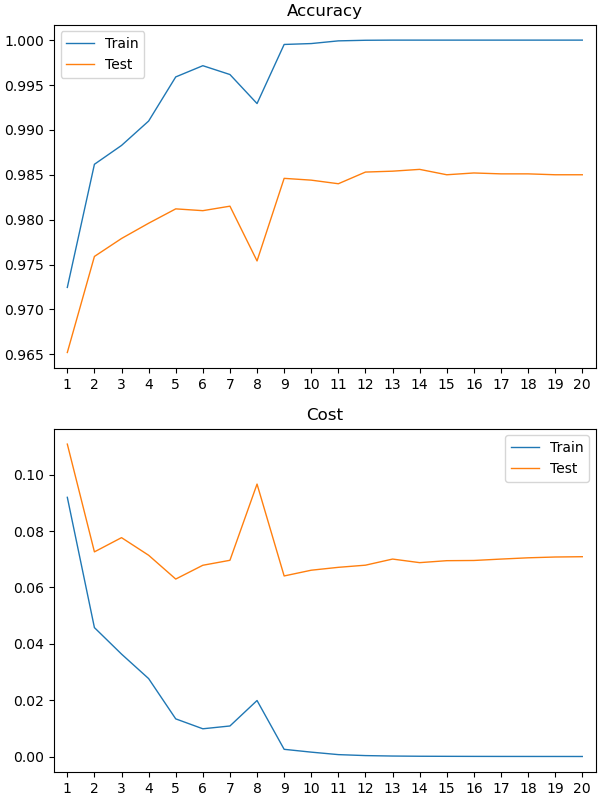

In [22]:
tracker = models.EpochTracker(X_train, X_test, y_train, y_test)
nn3l = models.train_nn(init_nn3l, X_train, X_test, y_train, y_test, seed=seed, epoch_fn=tracker.evaluate_epoch)
tracker.show_training()

This network can also be trained in a couple of minutes and is only a little bit slower than the previous network.

 Params: 266610
Predict: 0:00:00.119
  Score: 98.51%
   Cost: 0.07051562


<IPython.core.display.Javascript object>


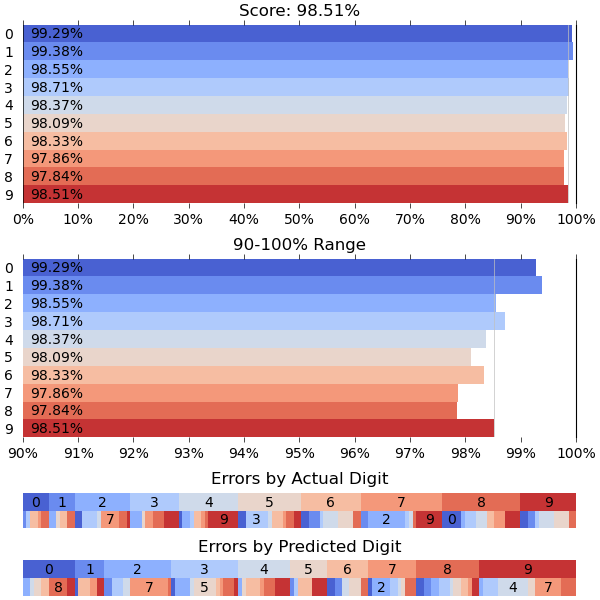

In [23]:
y_pred_nn3l, Y_prob_nn3l = models.evaluate_nn(nn3l, X_test, y_test)
mnist_visuals.show_performance(y_test, y_pred_nn3l)

The results are marginally better with an extra layer, but when the accuracy is already very high, small gains should not be ignored. E.g., if the accuracy is 99%, a 0.1% gain in accuracy translates to 10% fewer errors. As before, the predictions are lightning-fast. This network also adds ~28,000 parameters.

### Modern LeNet-5

To push the accuracy above 99%, we need to use a different architecture. Here, we will use a modern version of LeNet-5. It has the same basic structure:

*   `Input       (m, 28, 28,  1)`
*   `Convolution (m, 28, 28,  6): n_C=6, kernel_size=5, padding=2`
*   `Pool        (m, 14, 14,  6): pool_size=2`
*   `Convolution (m, 10, 10, 16): n_C=16, kernel_size=5`
*   `Pool        (m,  5,  5, 16): pool_size=2`
*   `Flatten     (m, 400)`
*   `Dense       (m, 120)`
*   `Dense       (m,  84)`
*   `Output      (m,  10)`

Like the original LeNet-5, this network will also be trained for 20 epochs, but some details have been changed to reflect more modern knowledge:

*   Weights are initialized using the Glorot uniform distribution.
*   ReLU activation is used for the convolutional and dense layers.
*   Max pooling is used.
*   The output layer uses softmax activation with a cross-entropy cost function.
*   An Adam optimizer is used with the typical parameters.
*   The network is trained on a mini-batches of size 32, with the mini-batch size doubling every 4 epochs.
*   The samples are shuffled before each epoch. For the last mini-batch, the entire training set is resampled to obtain a full mini-batch.
*   Weight decay (0.01) is used.

In [24]:
def init_lenet5():
    return NeuralNetwork(
        "lenet5",
        preprocess_fn=mnist_data.preprocess_channel,
        hidden_layers=[
            nn_layers.convolution_2d(28, 28, 1, 6, kernel_size=5, padding=2),
            nn_layers.max_pool_2d(28, 28, 6, pool_size=2),
            nn_layers.convolution_2d(14, 14, 6, 16, kernel_size=5),
            nn_layers.max_pool_2d(10, 10, 16, pool_size=2),
            nn_layers.flatten((5, 5, 16)),
            nn_layers.dense(400, 120),
            nn_layers.dense(120, 84),
        ],
        output_layer=nn_layers.multiclass_output(84, 10),
        optimizer=nn_optimizers.adam())

This network takes over an hour to train, so that will effect on one's ability to iterate and tune the model&mdash;though training would be faster with a deep learning framework such as Keras and better hardware. Here, we will copy-and-paste the output from training and load the pre-trained weights instead.

```
....................
Train: 1:18:57.634
```

![Training LeNet-5](pretrain/lenet5-training.png)

 Params: 61706
Predict: 0:00:18.627
  Score: 99.30%
   Cost: 0.03356232


<IPython.core.display.Javascript object>


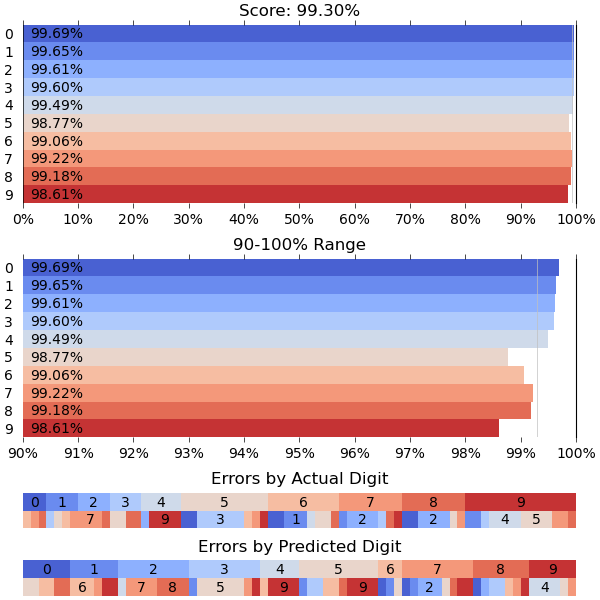

In [25]:
lenet5 = init_lenet5()
models.load_nn(lenet5)
y_pred_lenet5, Y_prob_lenet5 = models.evaluate_nn(lenet5, X_test, y_test)
mnist_visuals.show_performance(y_test, y_pred_lenet5)

The accuracy here passes not just 99%, but also 99.3%. By comparison, an accuracy of 99.05% was reported for the original LeNet-5 architecture. Furthermore, this network has about 4x fewer parameters than the previous 3-layer dense network.

The prediction time does get slower, but a single prediction still only takes a couple of milliseconds. Furthermore, these predictions would also be faster using a deep learning framework; when this architecture is created in Keras, Keras can predict all 10,000 test samples in only a few seconds.

Next, let's take a look at some of the incorrect predictions:

<IPython.core.display.Javascript object>


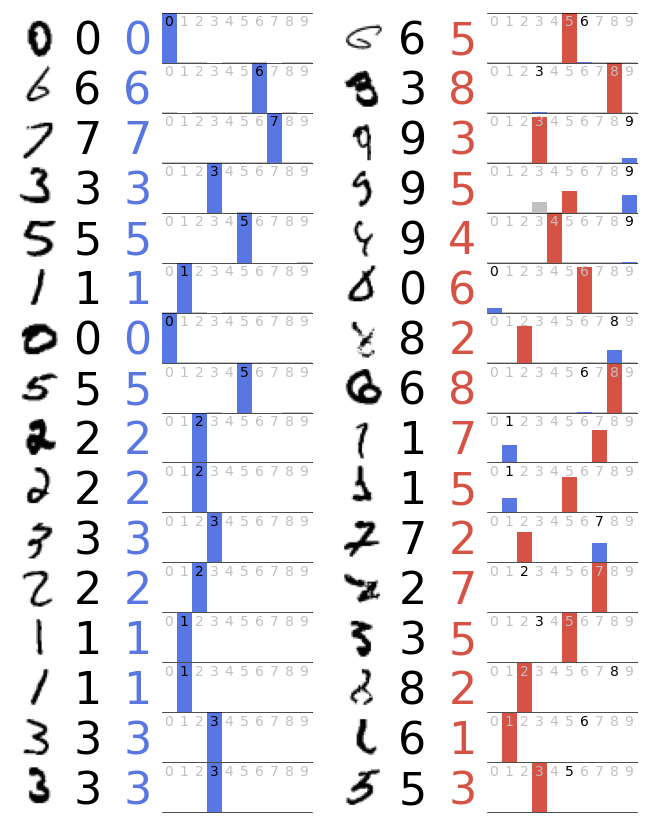

In [26]:
np.random.seed(0)
mnist_visuals.show_predictions(X_test, y_test, y_pred_lenet5, Y_prob_lenet5)

Some of these samples would even be difficult for a human to recognize, and the handwriting for most of these samples is certanly less than stellar.

One common source of errors was confusing the digits 4 and 9, so let's dive into those errors:

<IPython.core.display.Javascript object>


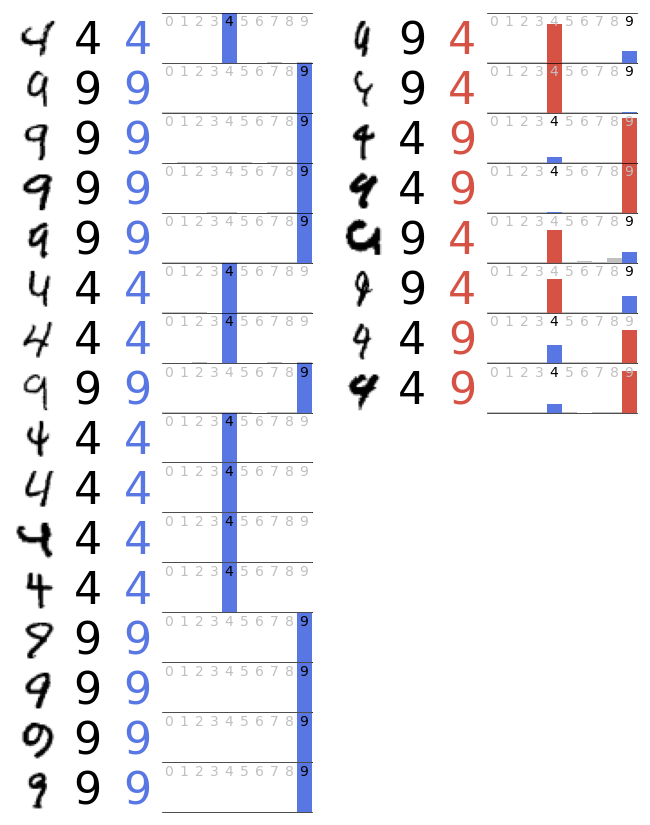

In [27]:
np.random.seed(0)
mnist_visuals.show_predictions(
    X_test, y_test, y_pred_lenet5, Y_prob_lenet5, true_digits=[4, 9], pred_digits=[4, 9])

For many of these samples, even a human would have a hard time telling if it was a 4 or a 9.

### Table of Results

To recap, here is a summary of all the machine learning models we tried, and the accuracy for each:

Model                 | Accuracy
----------------------|----------
Naive Bayes           | 55.58%
Logistic Regression   | 92.58%
K Nearest Neighbors*  | 96.88%
1-Layer NN            | 92.74%
2-Layer NN (300)      | 98.41%
3-Layer NN (300, 100) | 98.51%
Modern LeNet-5        | 99.30%

\*Predictions were very slow with this model.

## Appendix: Reproduciblity

### Random Trials

Since the training process involves some randomness, we ran 5 trials with 5 random seeds: 0 and 4 random numbers in the range \[0, 1000000). We want a result that was replicated in multiple trials, so we picked the seed with the second-best result for LeNet-5.

|          |           |     000000 |     378039 |     501968 |     757431 |     924519 |
|:--------:|:---------:|------------|------------|------------|------------|------------|
| `nn1l  ` | **score** |     92.80% |     92.78% |     92.74% |     92.78% |     92.80% |
|          | **cost**  | 0.26035239 | 0.26056829 | 0.26157103 | 0.26140097 | 0.26053311 |
|          |           |            |            |            |            |            |
| `nn2l  ` | **score** |     98.45% |     98.41% |     98.41% |     98.34% |     98.41% |
|          | **cost**  | 0.05881709 | 0.05793530 | 0.06146228 | 0.06496046 | 0.05998135 |
|          |           |            |            |            |            |            |
| `nn3l  ` | **score** |     98.47% |     98.45% |     98.51% |     98.50% |     98.62% |
|          | **cost**  | 0.07306178 | 0.07069950 | 0.07051562 | 0.07213257 | 0.06784449 |
|          |           |            |            |            |            |            |
| `lenet5` | **score** |     99.18% |     99.42% |     99.30% |     99.25% |     99.24% |
|          | **cost**  | 0.03929587 | 0.02797894 | 0.03356232 | 0.03159152 | 0.03264676 |
|          |           |            |            |            |            |            |

If we wanted to take the best trial instead, we could report 99.42% accuracy.

### Determinism

Since the training process involves some randonmness, we also needed to ensure that the results are deterministic for a chosen seed.

The neural network has two sources of randomness:

1.  Weights are initialized with random values from a Glorot uniform distribution.
1.  The samples are randomly shuffled (and possibly resampled) before each epoch.

During the training process, we also save the weights (and additional state) after each epoch. The training process can be stopped and later resumed from a given epoch, so long as the weights from the previous epoch were saved. However, the state of the random number generator is not saved.

Instead, the chosen seed acts as a master seed, and this master seed is used to generate a sequence of random seeds. The first seed is used for initializing the network, and each subsequent seed is used for each epoch. (E.g., the 5th seed in the sequence is used to shuffle samples for the 4th epoch.)

In case it matters for random number generation, the OS used was Ubuntu 18.04.5 LTS, and the numpy version was 1.19.2.